In [2]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mne
mne.__version__
from mne.viz import plot_alignment, snapshot_brain_montage
import shutil
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split

# from mne_bids import write_raw_bids, BIDSPath, print_dir_tree, make_dataset_description
# from mne_bids.stats import count_events
import sys

from statsmodels.tsa.api import VAR



In [3]:
''' VARIABLES '''

dataset = 'eeg'

amount_of_subjects = 26 # Change the range so the process is faster

numC = 8

angles = [i * 180./numC for i in range(numC)]

x_labels = np.array(angles)

resample = False # speeds up the procees but showing worse results overall
resample_frequency = 20 # in Hz, original freq is 500Hz

In [4]:
from toolbox.methods import read_data
all_epochs, all_rawdata = read_data (task = 'main', resample=resample, amount_of_subjects=amount_of_subjects, resample_frequency=resample_frequency)

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

accuracy_scores = [[] for _ in range(26)]  # Nested list to store accuracy scores for each subject
print(accuracy_scores)
ml = True
for use_subject in range(amount_of_subjects):
    print(use_subject)
    X = all_rawdata[use_subject]['epoch_dat']
    X = np.delete(X, 25, axis=1)
    y = all_rawdata[use_subject]['metadata']['deci']
    
    for i in range(0, 2855, 10):
        if ml:

            slide_X = X[:, :, i:i+20]
            slide_X = np.reshape(slide_X, (slide_X.shape[0], -1))
            X_train, X_test, y_train, y_test = train_test_split(slide_X, y, test_size=0.2, random_state=42)
            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            accuracy_scores[use_subject].append(score)
        else:
            slide_X = X[:, i:i+10, :]
            params = np.array([VAR(slide_X[i]).fit(2).params.flatten() for i in range(X.shape[0])])
            X_train, X_test, y_train, y_test = train_test_split(params, y, test_size=0.2, random_state=42)
            clf = RandomForestClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            # accuracy_scores = np.append(accuracy_scores, score)

print(accuracy_scores)

    

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
[[0.6, 0.64, 0.7, 0.68, 0.68, 0.64, 0.62, 0.6, 0.62, 0.66, 0.74, 0.62, 0.62, 0.62, 0.66, 0.62, 0.6, 0.58, 0.7, 0.58, 0.56, 0.58, 0.62, 0.6, 0.62, 0.68, 0.7, 0.6, 0.56, 0.58, 0.6, 0.68, 0.64, 0.64, 0.66, 0.58, 0.58, 0.62, 0.68, 0.68, 0.66, 0.72, 0.66, 0.6, 0.66, 0.66, 0.66, 0.64, 0.62, 0.64, 0.58, 0.64, 0.6, 0.62, 0.6, 0.7, 0.62, 0.6, 0.62, 0.66, 0.58, 0.64, 0.64, 0.66, 0.62, 0.58, 0.6, 0.66, 0.6, 0.6, 0.6, 0.58, 0.58, 0.62, 0.66, 0.68, 0.66, 0.62, 0.64, 0.68, 0.64, 0.64, 0.62, 0.62, 0.62, 0.54, 0.56, 0.56, 0.6, 0.62, 0.64, 0.64, 0.64, 0.56, 0.58, 0.56, 0.56, 0.6, 0.68, 0.7, 0.7, 0.62, 0.6, 0.66, 0.64, 0.6, 0.6, 0.64, 0.66, 0.66, 0.66, 0.68, 0.6, 0.64, 0.68, 0.7, 0.64, 0.6, 0.68, 0.7, 0.68, 0.68, 0.62, 0.6, 0.66, 0.64, 0.66, 0.66, 0.68, 0.62, 0.56, 0.62, 0.62, 0.58, 0.64, 0.68, 0.68, 0.64, 0.62, 0.7, 0.58, 0.66, 0.62

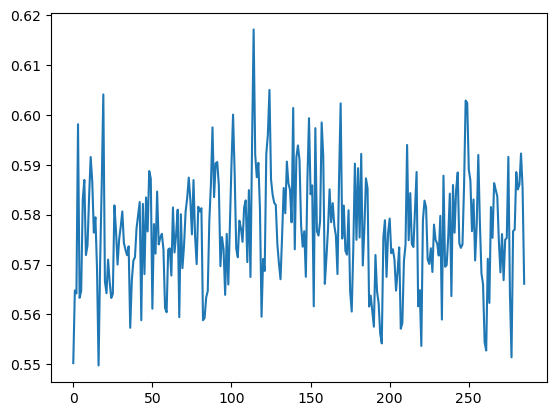

In [7]:
from scipy.ndimage import gaussian_filter
# acc_filtered = gaussian_filter(accuracy_scores, sigma=20) 
mean_accuracy = np.mean(accuracy_scores, axis=0)
mean_accuracy = gaussian_filter(mean_accuracy, sigma=20)

plt.plot(mean_accuracy)

In [61]:
# y = np.where(all_rawdata[use_subject]['metadata']['r_map'] == 45, 1, 0)
# y2 = all_rawdata[use_subject]['metadata']['deci']
# y3 = [a ^ b for a, b in zip(y, y2)]
# print(y3)

In [55]:
params = np.array([VAR(X[i]).fit(2).params.flatten() for i in range(X.shape[0])])

In [49]:
params.shape

(256, 1953)

In [56]:
from sklearn.model_selection import train_test_split
from pyrcn.echo_state_network import ESNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(params, y3, test_size=0.2, random_state=42)

clf = RandomForestClassifier()

# clf = CatBoostClassifier(task_type='GPU')

clf.fit(X_train, y_train)


RandomForestClassifier()

In [57]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(np.unique(y_test, return_counts=True))
print(np.unique(y_pred, return_counts=True))

              precision    recall  f1-score   support

           0       0.51      0.78      0.62        27
           1       0.33      0.13      0.19        23

    accuracy                           0.48        50
   macro avg       0.42      0.45      0.40        50
weighted avg       0.43      0.48      0.42        50

0.48
(array([0, 1]), array([27, 23]))
(array([0, 1]), array([41,  9]))


In [ ]:
arima end

In [18]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

def train_3(X, y, verbose=False, display_roc=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = CatBoostClassifier(task_type = 'GPU')
    clf = RandomForestClassifier()
    clf = SVC()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)    
    if verbose:
        print(classification_report(y_test, y_pred))
        print(np.unique(y_test, return_counts=True))
        print(np.unique(y_pred, return_counts=True))
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    if display_roc:
        from sklearn.metrics import roc_curve
        from sklearn.metrics import RocCurveDisplay
        fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=clf.classes_[1])
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        return roc_display
    return accuracy, f1, roc

In [19]:
numT = X.shape[2]
timepoint_accuracy = [None]*numT
timepoint_f1 = [None]*numT
timepoint_roc = [None]*numT
for timepoint in range(numT):
    print(timepoint)
    X_training = X[:,:,timepoint]
    timepoint_accuracy[timepoint], timepoint_f1[timepoint], timepoint_roc[timepoint] = train_3(X_training, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


KeyboardInterrupt: 

In [ ]:
print('f1 mean: ', np.mean(timepoint_f1))
print('acc mean: ', np.mean(timepoint_accuracy))
plt.plot(timepoint_f1)

# RESULTS

In [ ]:
X_training = X[:,:,1500]
print(train_3(X_training, y, verbose=True))

In [ ]:
from sklearn.svm import SVC
# from pyrcn.echo_state_network import ESNClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)



catboost and RF both on more data with stacked are perfoming the same

next im gonna add labels for the subjects


In [ ]:
display(all_rawdata[0]['metadata'].columns)

In [ ]:
print(multivariate)

# multivariate test?

https://pypi.org/project/pyts/

In [ ]:
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier

from pyts.datasets import load_basic_motions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)

print(X_train.shape, y_train.shape)

# scaler = StandardScaler()

clf = CatBoostClassifier(task_type = 'GPU')
clf = RandomForestClassifier()
clf = MultivariateClassifier(BOSSVS())
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

